# Utils

In [1]:
require(tidyverse)
require(surveillance)
require(cmdstanr)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: surveillance

Loading required package: sp

Loading required package: xtable

This is surveillance 1.22.0; see ‘package?surveillance’ or
https://surveillance.R-Forge.R-project.org/ for an overview.


Attaching package: ‘surveillance’


The following object is masked from ‘package:lubridate’:

    year


Loading required package: cmdstanr

This is cmdstanr version 0.6.1

- CmdStanR documentation and vignettes: 

In [2]:
figsize = \(width=8,height=4) options(repr.plot.width=width, repr.plot.height=height)

In [3]:
discretize = \(pdist) \(ts) pdist(ts) - pdist(ts-1)

In [4]:
conv_aux = \(x,y) {
    T = length(x)
    K = length(y)
    z = rep(0, T)
    for(t in 1:T) for(s in 1:min(K, t)) {
        z[t] = z[t] + x[t-s+1] * y[s]
    }
    z
}

conv = \(x,y) if(length(x) > length(y)) conv_aux(x,y) else conv_aux(y,x)

In [5]:
timeit = \(f) {
    since = Sys.time()
    res = f()
    print(Sys.time() - since)
    res
}

In [6]:
stan = \(code, dir='/tmp') {
    fn = write_stan_file(code, dir = dir)
    cmdstan_model(fn)
}

## define LaTeX macro
$$
\def\R{{\cal R}}
\def\dl{\displaystyle}
$$

$$
\R(t)
$$

$$
\frac{\dl\sum_{s=0} s}{N}
$$

# Data

## # of cases $c(t)$

Rows: 1209 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Date
dbl (48): ALL, Hokkaido, Aomori, Iwate, Miyagi, Akita, Yamagata, Fukushima, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


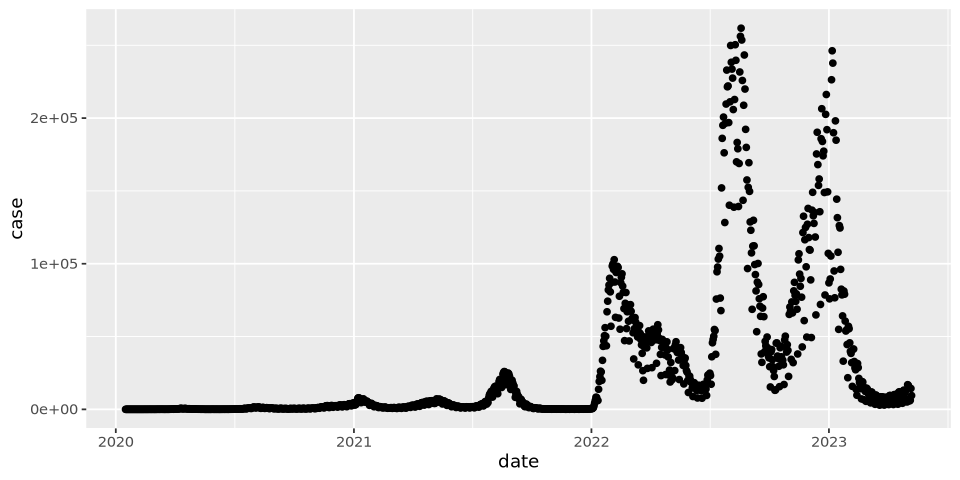

In [7]:
# https://www.mhlw.go.jp/stf/covid-19/open-data.html

df_case = read_csv('case_daily.csv') %>%
    transmute(date = as_date(Date), case = ALL)

figsize()
ggplot(df_case) +
geom_point(aes(date, case))

## # of vaccinations $v(t,k)$

Rows: 953 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (14): count_first_shot_general, count_second_shot_general, count_third_...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


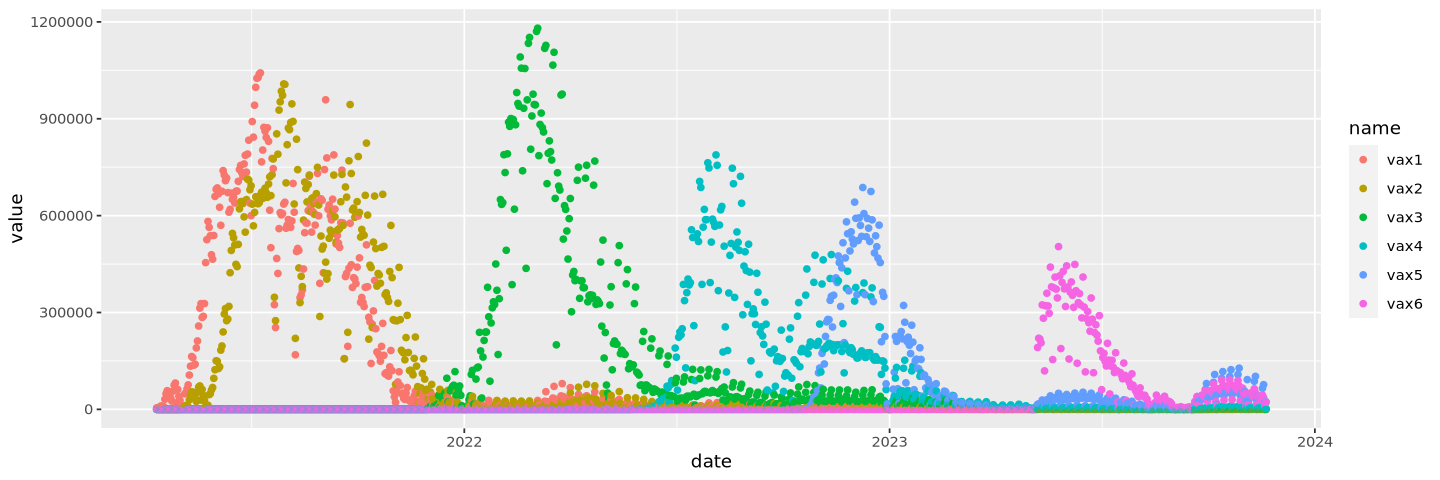

In [8]:
# https://info.vrs.digital.go.jp/dashboard/

df_vax = read_csv('vaccine_daily.csv') %>%
    transmute(
        date,
        vax1=count_first_shot_general,
        vax2=count_second_shot_general,
        vax3=count_third_shot_general,
        vax4=count_fourth_shot_general,
        vax5=count_fifth_shot_general,
        vax6=count_sixth_shot_general,
    )

figsize(width=12)
df_vax %>%
pivot_longer(-date) %>%
ggplot() +
geom_point(aes(date, value, col=name))

## Vaccine profile $h(s)$

$$
h(s) = \begin{cases}
\displaystyle \max\left(0, 0.95 \frac{s}{35} \right) 
& s < 35 \\
\displaystyle \max\left(0, 0.95 - 0.35 \frac{s-35}{150-35} \right)
& s \ge 35 \\
\end{cases}
$$

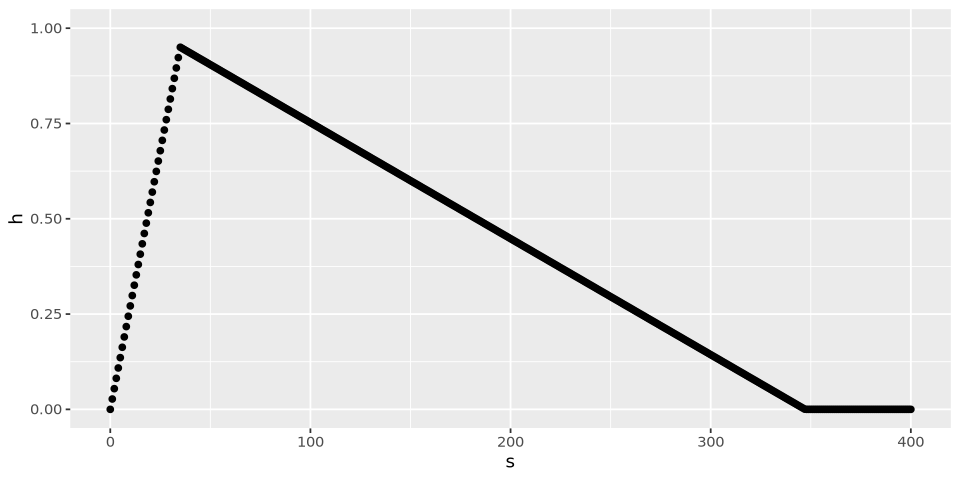

In [9]:
# https://www.nature.com/articles/s41598-023-44942-6

ve_inf = \(s) if_else(s < 35, pmax(0, .95*s/35), pmax(0, .95-.35*(s-35)/(150-35)))

figsize(width=8)
tibble(s = seq(0,400)) %>% 
mutate(h = ve_inf(s)) %>%
ggplot() +
geom_point(aes(s, h)) +
lims(y = c(0,1))

In [10]:
vax_profile = ve_inf(seq(0,400))

## Generation time $g(s)$ 

$$
g(s) \sim {\rm Weibull}({\rm shape} = 2.305, {\rm scale}=5.452)
$$

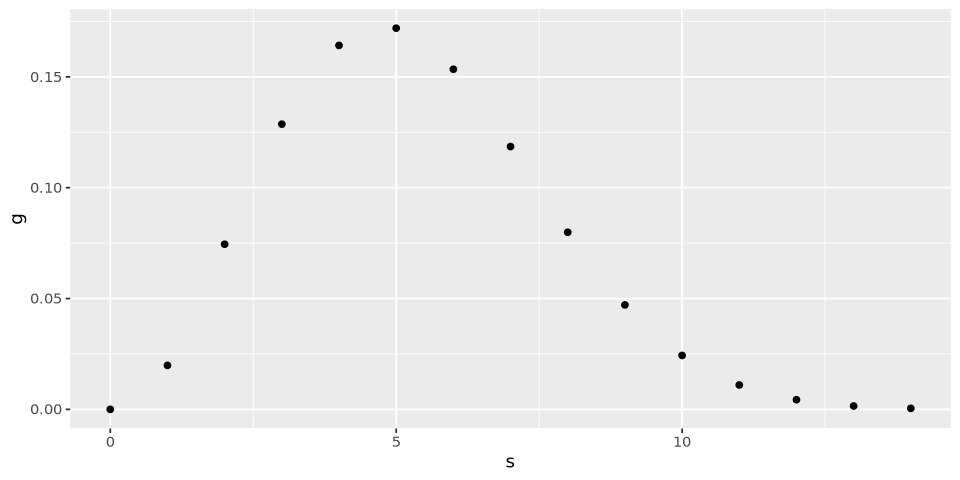

In [11]:
# https://www.nature.com/articles/s41598-023-44942-6

inf2inf = \(s) pweibull(s, shape=2.305, scale=5.452)

figsize(width=8)
tibble(s = seq(0,14)) %>%
mutate(g = discretize(inf2inf)(s)) %>%
ggplot() +
geom_point(aes(s,g))

In [12]:
generation_time = discretize(inf2inf)(seq(0,14))
generation_time = generation_time / sum(generation_time)

## Reporting delay $f(s)$

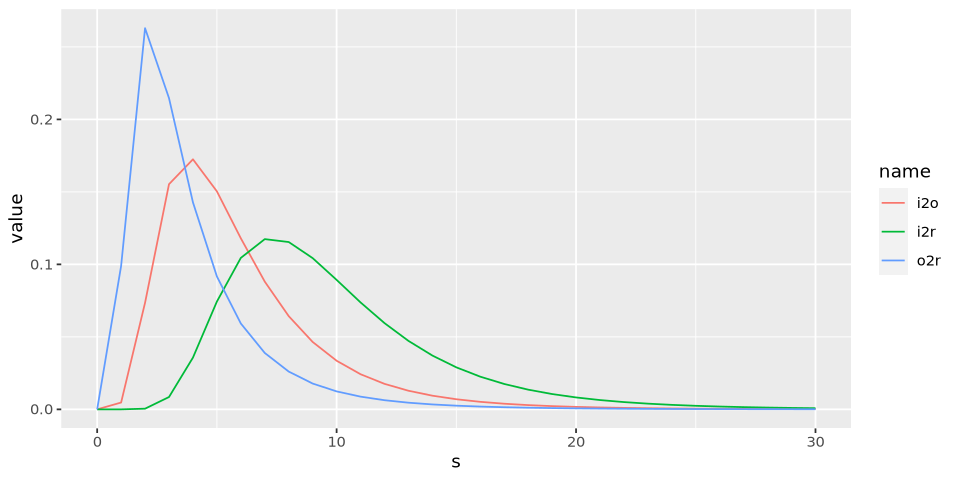

In [13]:
# https://www.nature.com/articles/s41598-023-44942-6

inf2onset = \(s) plnorm(s, meanlog = log(4.6), sdlog = log(1.8))
onset2report = \(s) plnorm(s, meanlog = log(2.6), sdlog = log(2.1))

figsize(width=8)
tibble(s = seq(0,30)) %>%
mutate(
    i2o = discretize(inf2onset)(s),
    o2r = discretize(onset2report)(s),
    i2r = conv(i2o, o2r)
) %>%
pivot_longer(-s) %>%
ggplot() +
geom_line(aes(s, value, color=name))

In [14]:
reporting_delay = conv(discretize(inf2onset)(seq(0,30)),
                       discretize(onset2report)(seq(0,30)))

reporting_delay = reporting_delay / sum(reporting_delay)

## Mobility $m(t)$

$$
m(t) = {\boldsymbol \alpha(t)}^\top {\boldsymbol \omega}
$$
where Google's mobility ${\boldsymbol \alpha(t)} = [\alpha_c(t)]^\top$ and relative importance of categories ${\boldsymbol \omega} = [\omega_c]^\top \,,\ \omega_c \ge 0 \,,\ \sum_c \omega_c = 1$ for each categories $c$.

Rows: 974 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): country_region_code, country_region, place_id
dbl  (6): retail_and_recreation_percent_change_from_baseline, grocery_and_ph...
lgl  (5): sub_region_1, sub_region_2, metro_area, iso_3166_2_code, census_fi...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Removed 3648 rows containing missing values (`geom_line()`).”


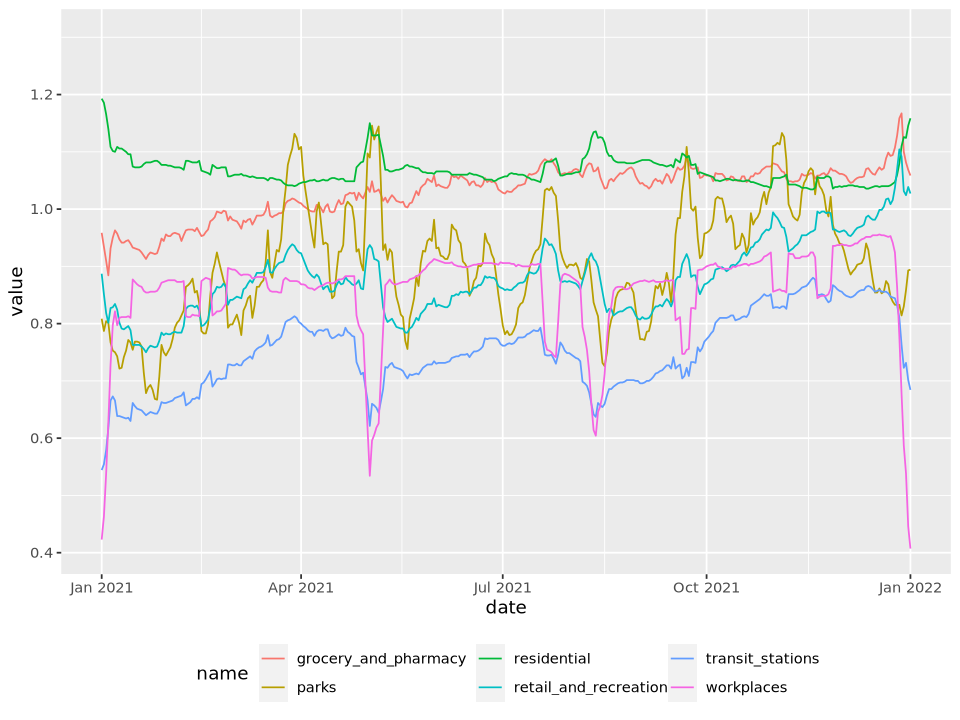

In [15]:
# https://www.google.com/covid19/mobility/

df_mob = read_csv('mobility.csv') %>%
    select(date, ends_with('baseline')) %>%
    rename_with(~ gsub('(.*)_percent_.*', '\\1', .), ends_with('baseline')) %>%
    mutate(across(-date, ~ 1 + ./100))

figsize(8,6)
df_mob %>%
mutate(across(-date, ~ . %>% conv(rep(1/7,7)) %>% lead(3))) %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value, color=name)) +
theme(legend.position = 'bottom') +
scale_x_date(limits = c(ymd('2021/1/1'), ymd('2022/1/1')))

In [16]:
cat_mob = colnames(df_mob %>% select(-date))
cat_mob

[1] "retail_and_recreation" "grocery_and_pharmacy"  "parks"                
[4] "transit_stations"      "workplaces"            "residential"

# Model

## Transmission

The number of new infections $i(t)$ follows
$$
i(t) = 
\begin{cases}
0 & t < 0 \\
\dl \R(t) \sum_{s = 1}^\infty i(t-s) g(s) & t \ge 0
\end{cases}
$$
with reproduction number $\R(t)$
$$
\R(t) = \R_0 m(t) \left( \frac{N - \sum_{s=1}^\infty v(t-s) h(s) - \sum_{s=1}^\infty i(t-s)}{\dl N} \right)
$$

## Observation

The number of cases $c(t)$ are drawn from
$$
\begin{align}
c(t) & \sim P(o(t); \theta) \\
o(t) & = \rho \sum_{s=1}^\infty i(t-s) f(s)
\end{align}
$$
with reporting rate $\rho$.

In [17]:
reporting_rate = 1/3

# Calculation

## Analysis set

Warning message:
“1 unknown level in `f`: date”
Warning message:
“1 unknown level in `f`: date”
Warning message:
“1 unknown level in `f`: date”


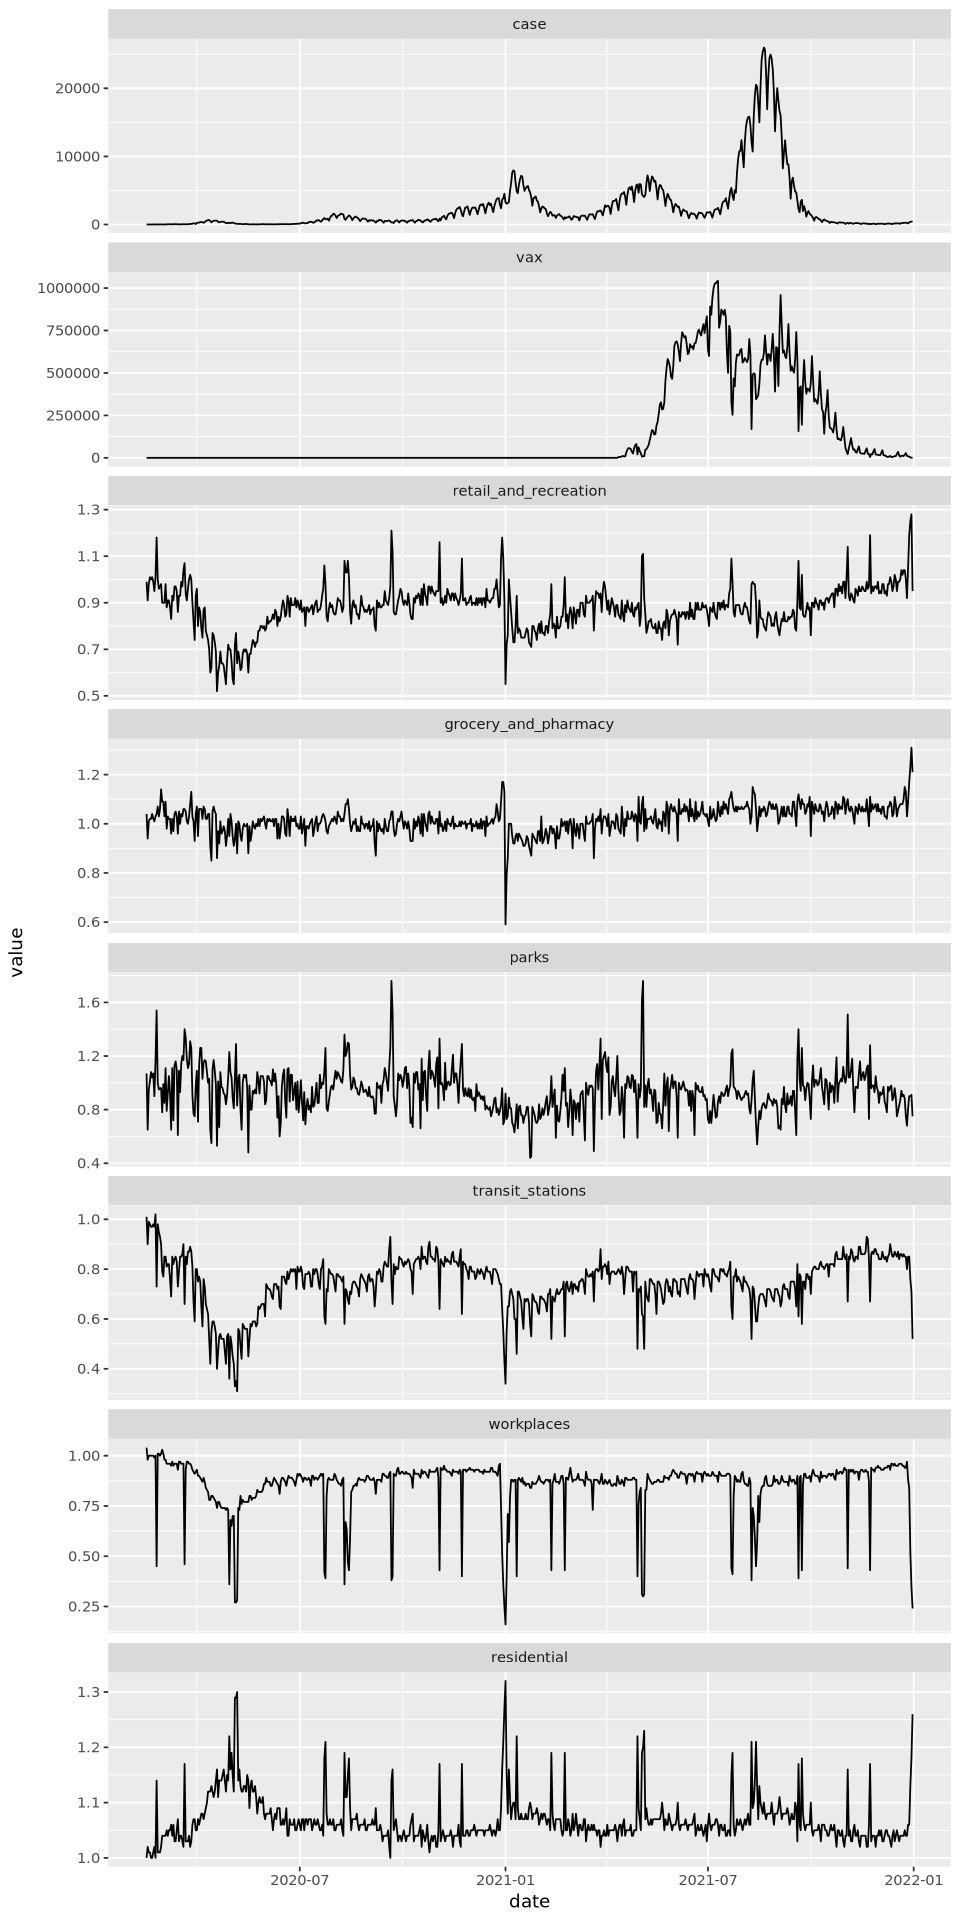

In [18]:
df = df_case %>%
    left_join(df_vax, by=join_by(date)) %>%
    right_join(df_mob, by=join_by(date)) %>%
    filter(date < ymd('2022/1/1')) %>%
    replace(is.na(.), 0) %>%
    transmute(
        date,
        case,
        vax=vax1, # vax_profile is the VE after 1st shot.
        across(all_of(cat_mob))
    )

figsize(height=16, width=8)
df %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value)) +
facet_wrap(~ fct_relevel(name, colnames(df)), ncol=1, scales = 'free_y')

## `backprojNP` and its Stan version

In [19]:
infer_backproj = stan(dir = './', code = '
#include utils.stan

data {
    int T; vector[T] observed;
    int K; vector[K] delay;
    real relative_change;
}
parameters {
    vector<lower=0>[T] original;
}
transformed parameters {
    vector[T] observed_hat = conv(original, delay);
}
model {
    target += poisson_lpdf(observed | observed_hat + 1e-3);
    target += normal_lpdf(original[2:T] | original[1:(T-1)], original[1:(T-1)] * relative_change);
}
')

In [20]:
inf_stan = timeit(\() {
    infer_backproj[['optimize']](
        refresh = 0,
        init = \() list(
            original = df[['case']]
        ),
        data = list(
            T = nrow(df),
            observed = df[['case']],
            K = length(reporting_delay),
            delay = reporting_delay,
            relative_change = 1/100
        )
    )[['mle']]('original')
})

Finished in  0.4 seconds.
Time difference of 0.8524485 secs


In [21]:
inf_surv = timeit(\() {
    upperbound(backprojNP(sts(df[['case']]), reporting_delay,
                          control = list(eq3a.method = 'C')))
})

Time difference of 1.225746 secs


Warning message:
“Transformation introduced infinite values in continuous y-axis”


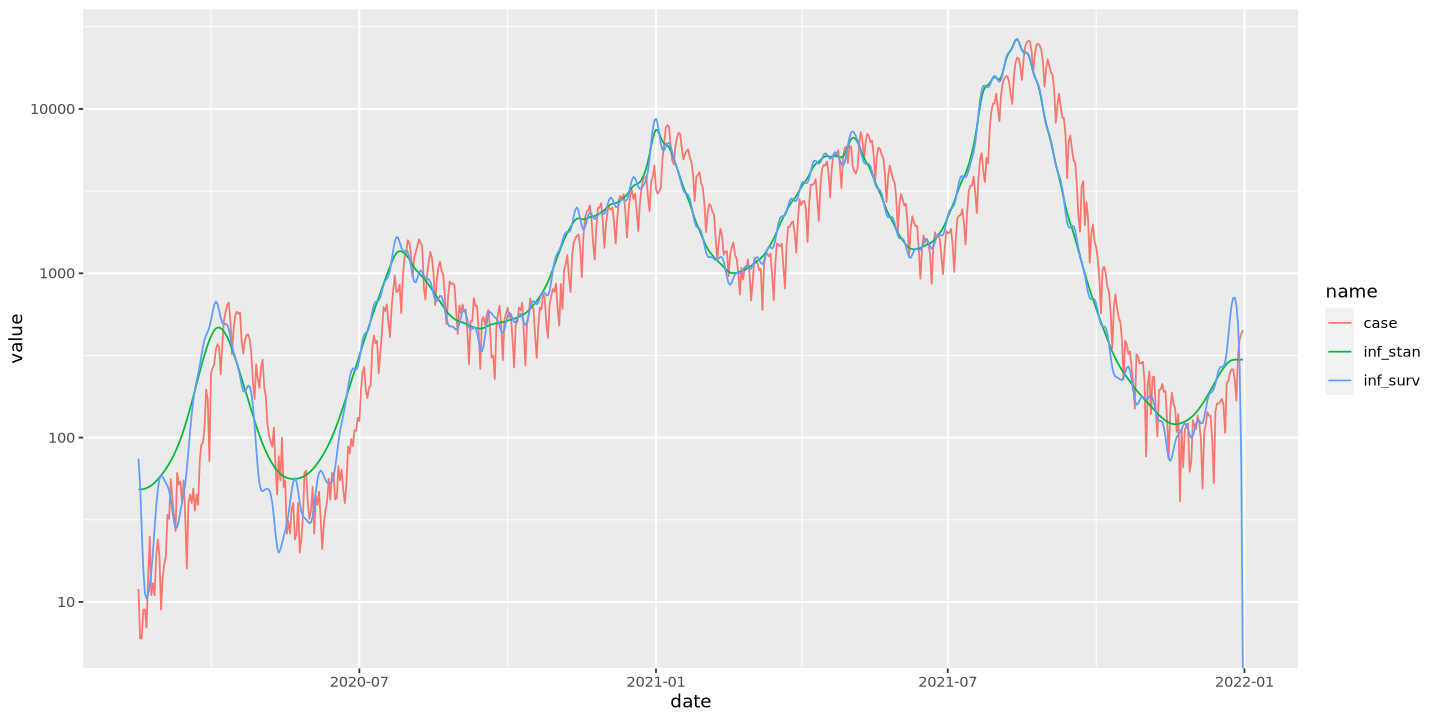

In [22]:
figsize(width=12, height=6)
df %>% transmute(date, case, 
                 inf_stan, inf_surv,
                ) %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value, col=name)) +
scale_y_log10()

## Inference of model parameters

In [23]:
# https://github.com/contactmodel/COVID19-Japan-Reff

stan_infer_model = stan(dir = './', code = '
#include utils.stan

data {
    int N;
    int T; vector[T] case, vax;
    int C; matrix[T,C] mobility;
    int Tv; vector[Tv] vax_profile;
    int Tg; vector[Tg] generation_time;
    int Tr; vector[Tr] reporting_delay;
    real reporting_rate;
}
parameters {
    real<lower=0> R0;
    simplex[C] omega;
    vector<lower=0>[T] inf;
}
transformed parameters {
    vector[T] mt = mobility * omega;
    vector[T] St = (N - conv(vax, vax_profile) - cumulative_sum(inf))/N;
    vector[T] Rt = R0 * mt .* St;

    vector[T] case_hat = reporting_rate * conv(inf, reporting_delay);
    vector[T] inf_hat = Rt .* conv(inf, generation_time);
}
model {
    // observation
    target += poisson_lpdf(case | case_hat + 1e-3);
    // transmission
    target += poisson_lpdf(inf | inf_hat+1e-3);
}
')

In [24]:
est_model = stan_infer_model[['optimize']](
    refresh = 0,
    init = \() list(inf = df[['case']] / reporting_rate),
    data = list(
        N = 125e6,
        T = nrow(df), case = df[['case']], vax = df[['vax']],
        C = length(cat_mob), mobility = df[cat_mob],
        Tv = length(vax_profile), vax_profile = vax_profile,
        Tg = length(generation_time), generation_time = generation_time,
        Tr = length(reporting_delay), reporting_delay = reporting_delay,
        reporting_rate = reporting_rate
    )
)

mle = est_model[['mle']]

Init values were only set for a subset of parameters. 
Missing init values for the following parameters:
R0, omega




Finished in  4.6 seconds.


In [25]:
par_model = tibble(name = c('R0', cat_mob),
                   value = mle(c('R0', 'omega')))
par_model

name,value
<chr>,<dbl>
R0,1.22999e+00
retail_and_recreation,9.64576e-04
grocery_and_pharmacy,9.98956e-01
parks,3.62151e-05
transit_stations,7.63126e-06
workplaces,1.18865e-05
residential,2.39230e-05


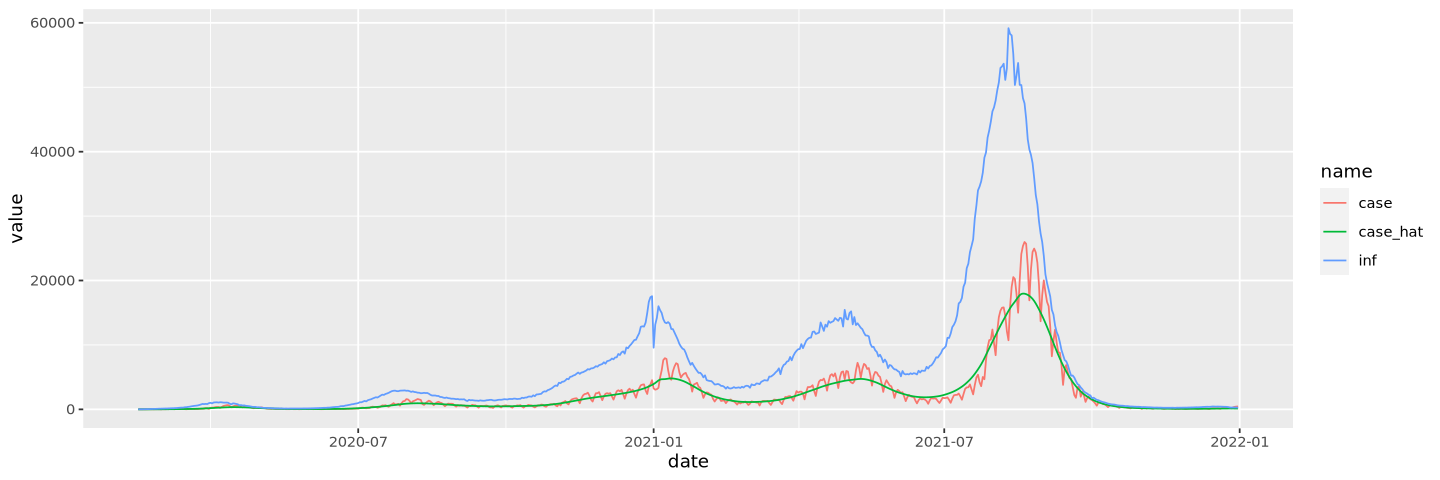

In [26]:
figsize(width=12)
df %>% transmute(
    date,
    case,
    inf = mle('inf'),
    case_hat = mle('case_hat')
    ) %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value, col=name))

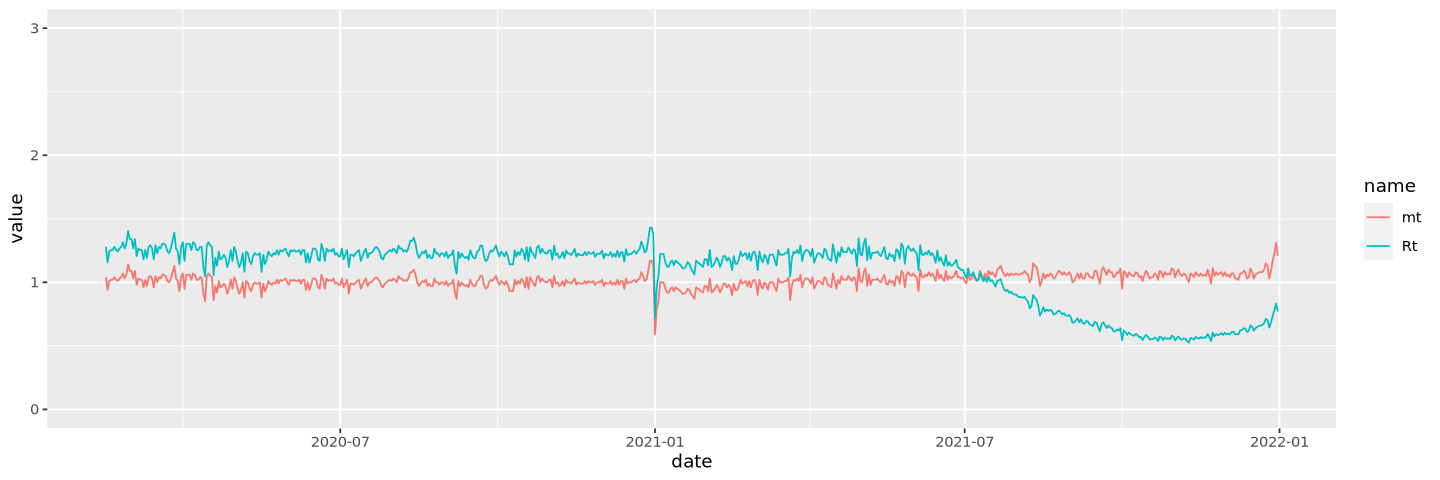

In [27]:
figsize(width=12)
df %>% transmute(
    date, 
    Rt = mle('Rt'),
    mt = mle('mt')
) %>%
pivot_longer(-date)%>%
ggplot() +
geom_line(aes(date, value, col=name)) +
lims(y=c(0,3))

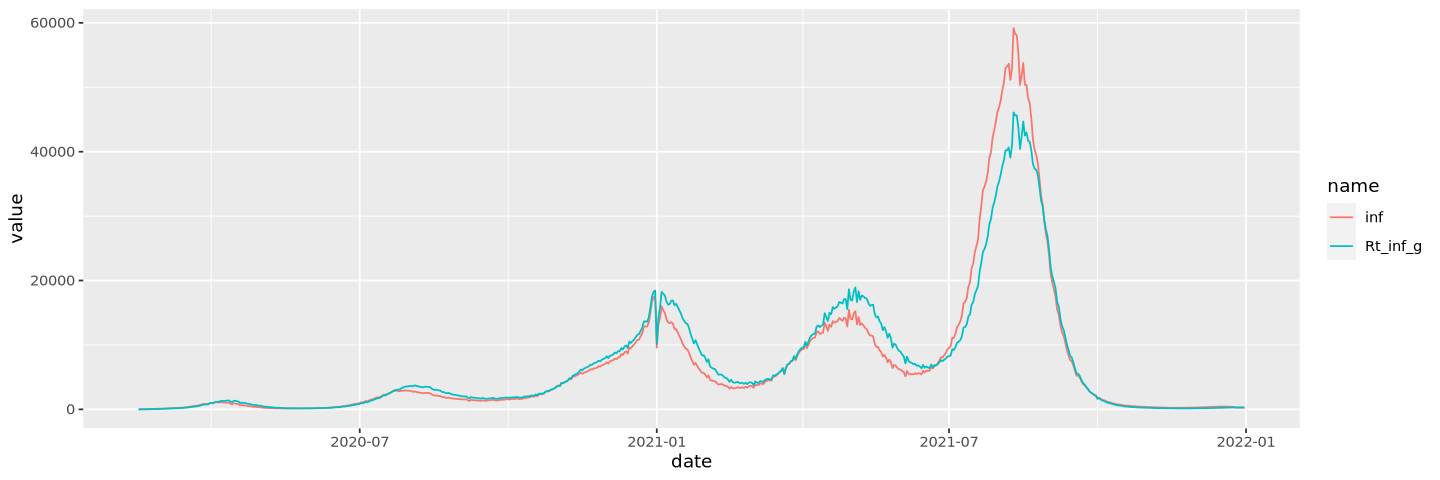

In [28]:
figsize(width=12)
tibble(
    date = df[['date']],
    inf = mle('inf'),
    Rt_inf_g = mle('Rt') * conv(mle('inf'), generation_time)
    ) %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value, col=name)) 
# scale_y_log10()

## Counterfactual calculation

In [29]:
# 1st day of vaccination
df[['date']][df[['vax']] != 0][1]

[1] "2021-04-12"

In [30]:
inf_mle = mle('inf')

In [31]:
reporting_rate

[1] 0.3333333

In [32]:
par_model

name,value
<chr>,<dbl>
R0,1.22999e+00
retail_and_recreation,9.64576e-04
grocery_and_pharmacy,9.98956e-01
parks,3.62151e-05
transit_stations,7.63126e-06
workplaces,1.18865e-05
residential,2.39230e-05


In [33]:
R0 = c(pivot_wider(par_model))[['R0']]
omega = as_vector(c(pivot_wider(par_model))[cat_mob])
since = '2021/4/1'
N = 125e6

simulate = \(vax) {
    t_since = which(df[['date']] >= since)[1]
    T = nrow(df)
    mt = as.matrix(df[cat_mob]) %*% omega
    conv_vax = conv(vax, vax_profile)
    inf_hat = inf_mle[]
    K = length(generation_time)
    for(t in t_since:T) {
        inf_acc = sum(inf_hat[1:(t-1)])
        St = (N - conv_vax[t] - inf_acc) / N
        Rt = R0 * mt[t] * St
        for(s in 2:min(K,t)) {
            inf_hat[t] = inf_hat[t] + Rt * inf_hat[t-s+1] * generation_time[s]
        }
    }
    reporting_rate * conv(inf_hat, reporting_delay)
}

Warning message:
“Removed 1605 rows containing missing values (`geom_line()`).”


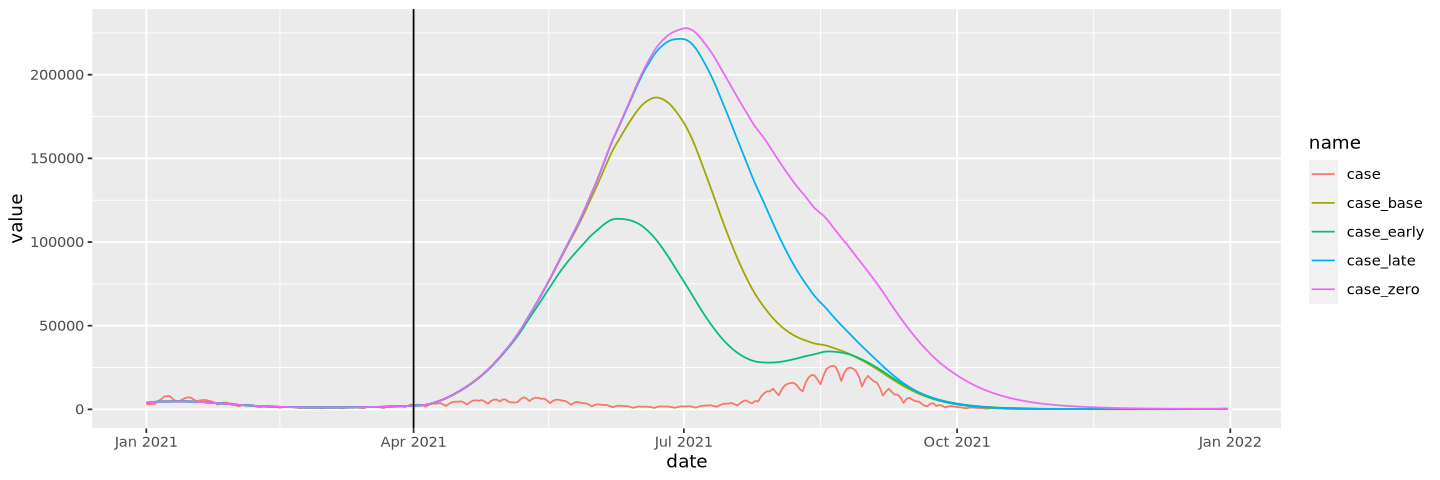

In [34]:
vax = df[['vax']]
case_base = simulate(vax = vax)
case_early = simulate(vax = lead(vax, 28, 0))
case_late = simulate(vax = lag(vax, 28, 0))
case_zero = simulate(vax = vax * 0)

figsize(width=12)
df %>% transmute(
    date, case, 
    case_base,
    case_early,
    case_late,
    case_zero
) %>%
pivot_longer(-date) %>%
ggplot() +
geom_line(aes(date, value, col=name)) +
geom_vline(xintercept = ymd(since)) +
lims(x = ymd(c('2021/1/1', NA)))
# scale_y_log10()